In [1]:
%pylab inline
%load_ext version_information

Populating the interactive namespace from numpy and matplotlib


In [2]:
from deltasigma import *
from IPython.core.display import Image
import pandas as pd

# Modulator realization and dynamic range scaling - # demo3

In this ipython notebook, the following is demonstrated:

 * A 5th order delta sigma modulator is synthesized, with optimized zeros and an OSR equal to 42.

 * We then convert the synthesized NTF into `a`, `g`, `b`, `c` coefficients for the `CRFB` modulator structure.
 
 * The maxima for each state are evaluated.
 
 * The `ABCD` matrix is scaled so that the state maxima are less than the specified limit.

 * The state maxima are re-evaluated and limit compliance is checked.

**NOTE:** This is an ipython port of `dsdemo3.m`, from the **[MATLAB Delta Sigma Toolbox](http://www.mathworks.com/matlabcentral/fileexchange/19-delta-sigma-toolbox)**, written by Richard Schreier.

## Delta sigma modulator synthesis

In [3]:
order = 5
R = 42
opt = 1
H = synthesizeNTF(order, R, opt)

Let's inspect the NTF, printing out the transfer function and plotting poles and zeros with respect to the unit circle.

In [4]:
print(pretty_lti(H))

        (z^2 - 1.995z + 1) (z^2 - 1.998z + 1) (z - 1)         
--------------------------------------------------------------
 (z^2 - 1.614z + 0.6657) (z^2 - 1.797z + 0.8552) (z - 0.7783) 


/usr/local/lib/python3.6/dist-packages/deltasigma/_plotPZ.py:85: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  hold_status = plt.ishold()
/usr/local/lib/python3.6/dist-packages/deltasigma/_plotPZ.py:90: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(True)
/usr/lib/python3/dist-packages/matplotlib/__init__.py:806: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/lib/python3/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


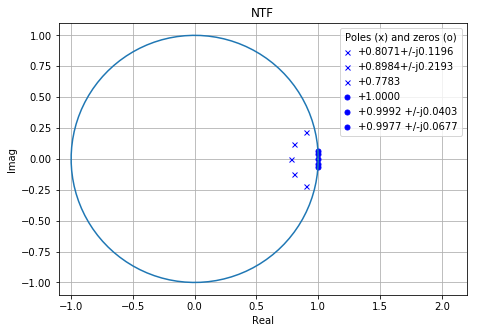

In [5]:
figure(figsize=(10, 5))
plotPZ(H, showlist=True)
title('NTF');

## Evaluation of the coefficients for a CRFB topology
The CRFB topology is depicted in the following diagram.

In [6]:
Image(url='http://python-deltasigma.readthedocs.org/en/latest/_images/CRFB.png', retina=True)

Since the modulator order is 5, we're interested in the topology for odd order modulators.

## Unscaled modulator

### Calculate the coefficients

In [7]:
a, g, b, c = realizeNTF(H)

### Feed-in selection
We'll use a single feed-in for the input, to have a maximally flat STF.

This means setting $\ b_n = 0, \ \forall n > 1$.

In [8]:
b = np.concatenate((b[0].reshape((1, )), np.zeros((b.shape[0] - 1, ))), axis=0)

In [9]:
t_sz = max([len(a), len(g), len(b), len(c)])
t_nan = [np.nan for x in range(t_sz)]
t = {'Coefficients' : ['#1', '#2', '#3', '#4', '#5', '#6'],
     'DAC feedback: a(n)' : (a.tolist()+t_nan)[:t_sz],
     'Resonator feedback: g(n)' : (g.tolist()+t_nan)[:t_sz],
     'Feed-in: b(n)' : (b.tolist()+t_nan)[:t_sz],
     'Interstage: c(n)' : (c.tolist()+t_nan)[:t_sz]}
pd.DataFrame(t)

,Coefficients,DAC feedback: a(n),Feed-in: b(n),Interstage: c(n),Resonator feedback: g(n)
0,#1,0.000667,0.000667,1.0,0.001622
1,#2,0.008583,0.000000,1.0,0.004593
2,#3,0.055201,0.000000,1.0,NaN
3,#4,0.247607,0.000000,1.0,NaN
4,#5,0.556935,0.000000,1.0,NaN
5,#6,NaN,0.000000,NaN,NaN


### Calculate the state maxima

In [10]:
ABCD = stuffABCD(a, g, b, c);
u = np.linspace(0, 0.6, 30);
N = 1e4; 
T = np.ones((1, int(N)))
maxima = np.zeros((order, len(u)))
for i in range(len(u)):
    ui = u[i]
    v, xn, xmax, _ = simulateDSM(ui*T, ABCD);
    maxima[:, i] = np.squeeze(xmax)
    if any(xmax > 1e2):
        umax = ui;
        u = u[:i];
        maxima = maxima[:, :i]
        break;
# save the maxima
prescale_maxima = np.copy(maxima)
print('The state maxima have been evaluated through simulation.')

The state maxima have been evaluated through simulation.


### Plot of the state maxima

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/matplotlib/__init__.py:806: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/lib/python3/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


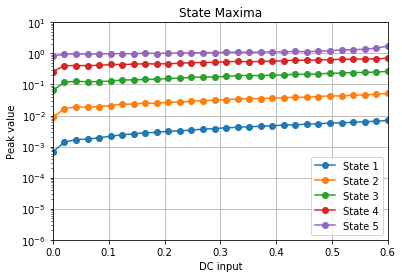

In [11]:
for i in range(order):
    semilogy(u, maxima[i, :], 'o-', label=('State %d' % (i+1)))
    if not i:
        hold(True)
grid(True)
title('State Maxima'); ylabel('Peak value'); xlabel('DC input')
xlim([0, 0.6]); ylim([1e-6, 10]);
legend(loc=4);

## Scaled modulator
### Calculate the scaled coefficients

In [12]:
ABCDs, umax, _ = scaleABCD(ABCD, N_sim=1e5)
as_, gs, bs, cs = mapABCD(ABCDs)
print('\nScaled modulator, umax = %.2f\n' % umax)


Scaled modulator, umax = 0.58



In [13]:
t_sz = max([len(as_), len(gs), len(bs), len(cs)])
t_nan = [np.nan for x in range(t_sz)]
t = {'Coefficients' : ['#1', '#2', '#3', '#4', '#5', '#6'],
     'DAC feedback: a(n)' : (as_.tolist()+t_nan)[:t_sz],
     'Resonator feedback: g(n)' : (gs.tolist()+t_nan)[:t_sz],
     'Feed-in: b(n)' : (bs.tolist()+t_nan)[:t_sz],
     'Interstage: c(n)' : (cs.tolist()+t_nan)[:t_sz]}
pd.DataFrame(t)

,Coefficients,DAC feedback: a(n),Feed-in: b(n),Interstage: c(n),Resonator feedback: g(n)
0,#1,0.100298,0.100298,0.135347,0.008508
1,#2,0.174656,0.000000,0.190649,0.010817
2,#3,0.214165,0.000000,0.380271,NaN
3,#4,0.365304,0.000000,0.424567,NaN
4,#5,0.348852,0.000000,1.596478,NaN
5,#6,NaN,0.000000,NaN,NaN


### Calculate the state maxima

In [14]:
u = np.linspace(0, umax, 30)
N = 1e4
T = np.ones((int(N),))
maxima = np.zeros((order, len(u)))
for i in range(len(u)):
    ui = u[i]
    v, xn, xmax, _ = simulateDSM(ui*T, ABCDs)
    maxima[:, i] = xmax.squeeze()
    if any(xmax > 1e2):
        umax = ui;
        u = u[:i]
        maxima = maxima[:, :i]
        break
print('The state maxima have been re-evaluated through simulation.')
print("The maximum input was found to be %.6f" % umax)

The state maxima have been re-evaluated through simulation.
The maximum input was found to be 0.583333


### Plot of the state maxima after scaling

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/matplotlib/__init__.py:806: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/lib/python3/dist-packages/matplotlib/rcsetup.py:155: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


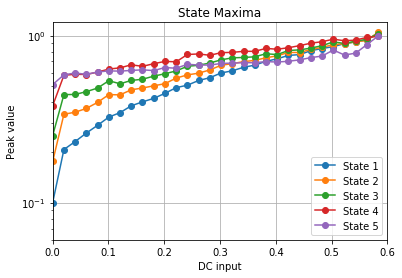

In [15]:
for i in range(order):
    semilogy(u, maxima[i, :], 'o-', label=('State %d' % (i+1)))
    if not i:
        hold(True)
grid(True)
title('State Maxima'); ylabel('Peak value'); xlabel('DC input')
xlim([0, 0.6]); ylim([6e-2, 1.2]);
legend(loc=4);

### System version information

In [16]:
%version_information numpy, scipy, matplotlib, deltasigma

Software versions
Python 3.6.8 64bit [GCC 8.3.0]
IPython 5.5.0
OS Linux 5.0.0 36 generic x86_64 with Ubuntu 18.04 bionic
numpy 1.13.3
scipy 0.19.1
matplotlib 2.1.1
deltasigma 0.2.3rc1
Thu Nov 28 11:07:23 2019 CST